NB to show how to read STScI's precompiled background estimates for the ETC.  Want to make my own bathtub curves of zody vs time.  
To read binary files, following tutorial at http://vislab-ccom.unh.edu/~schwehr/rt/python-binary-files.html

In [34]:
# File description from email V Laidler 23 March 2017
# C structure used to write the stray light binary file.
# One record per file.
#    typedef struct {
#              double pix_ra;
#              double pix_dec;
#              double pos[3];
#              double nonzodi_bg[SL_NWAVE];  // The in-field ism+cib for each pixel.
#            } sl_pix;
#              Then for every day with the target in the FOR,the following three items are written.
#              double day;
#              double zodi_bg[SL_NWAVE];  //  The combined in-field zodi for each pixel.
#              double stray_light_bg[SL_NWAVE];  //The equivalent in-field background from stray light from zodi, stellar,ism, cib
#The wavelength array is the standard one that we converged
#on last year, so they are all on the same wavelength array
#that is SL_NWAVE = 108 elements long.

In [35]:
import struct
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [47]:
thedir = "/Volumes/Apps_and_Docs/MISSIONS/JWST/Zody_bathtubs/"  # Satchmo
thedir = "/Users/jrrigby1/MISSIONS/JWST/Zody_bathtubs/" # Milk
wave_file = "updated_std_spectrum_wavelengths.txt"  # Standard wavelength array.  Should be SL_NWave=108 long
wave_array = np.loadtxt(thedir + wave_file)
myfiles = ('sl_pix_000593.bin','sl_pix_041303.bin','sl_pix_099422.bin','sl_pix_157139.bin','sl_pix_196512.bin')
myfile = "bg_samples_for_jane/" + myfiles[3]
#myfile = "bg_samples_for_jane/sl_pix_099422.bin" #
SL_NWAVE = len(wave_array)  # should be 108.  Size of wavelength array
sbet_file = open(thedir + myfile)
sbet_data = sbet_file.read()

In [63]:
print "File has", len(sbet_data), "bytes, which is", len(sbet_data)/8., "doubles"
size_calendar = 183 # There are 183*8 extra bytes for the calendar
allval = struct.unpack(str(len(sbet_data)/8) + 'd', sbet_data)
perday = SL_NWAVE*2  # size of a daily chunk
static = 5 + SL_NWAVE + size_calendar # data for position, not time-variable
Ndays = (len(allval)*1.0 - static)/ perday   # if we subtract 2 here, get Ndays as int
print "Warning, Ndays should be an integer. Is it?", Ndays
Ndays = int(Ndays)
print "debugging", struct.calcsize("365i")/8.

# Unpack the dates, which are integers
date_map = np.array(struct.unpack('365i', sbet_data[(5 + SL_NWAVE)*8  : static*8-4]))
print "Out of", len(date_map), "days, these many are legal:", np.sum(date_map >=0), "should=", Ndays
print "indices of days:", date_map[date_map>=0]
calendar = np.where(date_map >=0)[0]
print "calendar date:", calendar
# So, the index dd in zodi_bg[dd, : ]  corresponds to the calendar day lookup[dd]
cal2 = calendar[1:] 
print len(calendar), Ndays
print len(date_map), len(calendar)

File has 342784 bytes, which is 42848.0 doubles
Warning, Ndays should be an integer. Is it? 197.0
debugging 182.5
Out of 365 days, these many are legal: 196 should= 197
indices of days: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195]
calendar date: [  

In [64]:
print len(allval)-1, "is last index of allval"
print " ", static, "values true for all dates, plus"
print " ", perday, "values per day for", Ndays, "days"
RA = allval[0]
DEC = allval[1]
pos = allval[2:5]
nonzodi_bg = allval[5:5+SL_NWAVE]

42847 is last index of allval
  296 values true for all dates, plus
  216 values per day for 197 days


In [39]:
#day            = np.zeros(Ndays)
zodi_bg        = np.zeros((Ndays,SL_NWAVE))
stray_light_bg = np.zeros((Ndays,SL_NWAVE))
for dd in range(0, int(Ndays)):
    br1 = static +  dd*perday
    br2 = br1
    br3 = br2 + SL_NWAVE
    br4 = br3 + SL_NWAVE
    #print "Breaking at:", br1, br2, br3, br4, br2-br1, br3-br2, br4-br3
    #day[dd]               = allval[br1]  # Andrea pointed out there is no day here.
    zodi_bg[dd, ]        = allval[br2 : br3]
    stray_light_bg[dd, ] = allval[br3 : br4]
print br4, "was last double" 
#print "DEBUGGING", zodi_bg
#print "DEBUGGING", stray_light_bg

46736 was last double


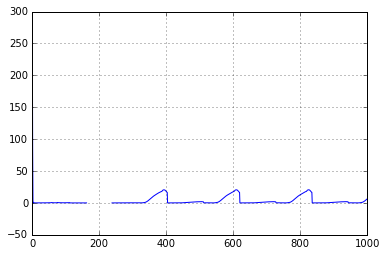

In [40]:
plt.plot(allval)
plt.xlim(0,1000)
#plt.ylim(0,30)
plt.grid()

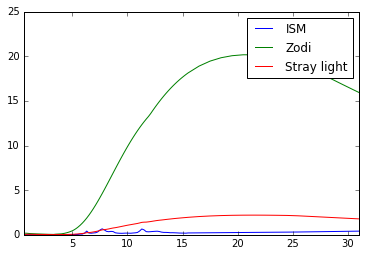

In [54]:
thisday = 100
plt.plot(wave_array, nonzodi_bg, label="ISM")
plt.plot(wave_array, zodi_bg[thisday, :], label="Zodi")
plt.plot(wave_array, stray_light_bg[thisday, :], label="Stray light")
plt.xlim(0.6,31)
plt.legend()

ValueError: x and y must have same first dimension

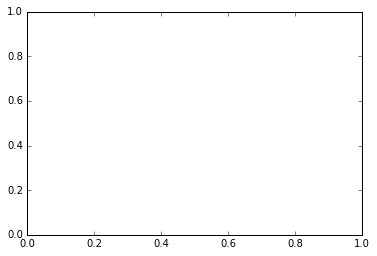

In [55]:
# Plot bathtub curve for 2um
print 
twomicron = 16 # 2.0 micron is index 16 in wave_array
plt.plot( calendar, zodi_bg[ : , twomicron])
themin = np.min(zodi_bg[ : , twomicron])
percentiles = (themin, themin*1.1)
plt.hlines(percentiles, 0, 365, color='green')
plt.xlabel("Day of the year")
plt.ylabel("bkg at " + str(wave_array[twomicron]) + " um (MJy/SR)")